<a href="https://colab.research.google.com/github/thiagotandrade/ds_project/blob/master/DS_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO: 
- ANALISAR O LOGERROR NA LIMPEZA DE DADOS (DETECÇÃO DE OUTLIERS, LEMBRAR DO KERNEL NO KAGGLE QUE FAZ ALGO PARECIDO)
- Escolher as melhores features (usar XGBoost, ver correlação entre variáveis e alvo).

# Projeto 1 da Disciplina Data Science 2019.1, CIn - UFPE
# Competição do Kaggle: [Zillow Prize](https://www.kaggle.com/c/zillow-prize-1)

## Configurando ambiente

### Imports

In [1]:
!pip install missingpy
!pip install pyspark

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import QuantileDiscretizer
from sklearn import preprocessing

sc = SparkContext('local')
spark = SparkSession(sc)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [0]:
# Variável para indicar se a imputação já foi feita anteriormente (salvar tempo de processamento)
imputed = True

### Lendo versão 2016 dos arquivos CSV

In [0]:
props = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/merged_2016v2.csv',
                    header=0, sep=',', quotechar='"')
props_bkp = props.copy()

## 2. Pré-processamento dos dados

In [4]:
props.tail().transpose()

,90270,90271,90272,90273,90274
parcelid,11876798,12808516,12010248,14310905,14636609
airconditioningtypeid,1,NaN,1,NaN,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,3,2,2,2.5,2.5
bedroomcnt,4,3,2,3,3
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,7,4,NaN,NaN
calculatedbathnbr,3,2,2,2.5,2.5
decktypeid,NaN,NaN,NaN,NaN,NaN


In [5]:
props.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,9.027500e+04,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,658.0,...,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04,90275.000000
mean,1.298466e+07,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,66.0,...,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13,0.011457
std,2.504510e+06,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,0.0,...,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11,0.161079
min,1.071174e+07,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,66.0,...,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13,-4.605000
25%,1.155950e+07,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,66.0,...,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13,-0.025300
50%,1.254734e+07,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,66.0,...,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,14.000000,6.037615e+13,0.006000
75%,1.422755e+07,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,66.0,...,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,15.000000,6.059042e+13,0.039200
max,1.629608e+08,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,66.0,...,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,99.000000,6.111009e+13,4.737000


In [0]:
# Não faz Sentido

# Inserir valor true na coluna 'fireplaceflag' se houve algum valor presente em fireplacecnt diferente de zero ou NaN
#props.loc[props['fireplacecnt'] != 0 | pd.notnull(props['fireplacecnt']),'fireplaceflag'] = "True"

### 2.1 Definição de tipos

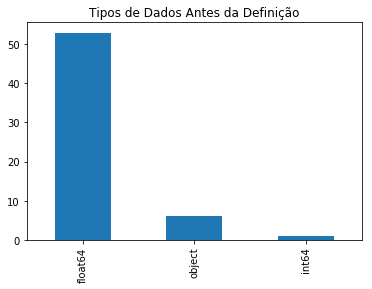

In [7]:
props_dtypes_before = props.dtypes.value_counts().sort_values(ascending=False)
props_dtypes_before.plot.bar(title='Tipos de Dados Antes da Definição')

In [0]:
# Mudando colunas de tipo 'object' para tipo 'category'
object_type = props.select_dtypes(include=['object']).columns.values
props[object_type] = props[object_type].astype('category')

#Mudar tipo da coluna transaction date para 'datetime64' e separando a data em colunas
props['transactiondate'] = pd.to_datetime(props['transactiondate'])
props['transaction_year'] = props['transactiondate'].dt.year
props['transaction_month'] = props['transactiondate'].dt.month
props['transaction_day'] = props['transactiondate'].dt.day
props.drop(['transactiondate'], axis=1, inplace=True)

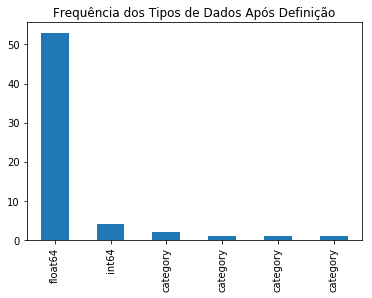

In [9]:
props_dtypes_after = props.dtypes.value_counts().sort_values(ascending=False)
props_dtypes_after.plot.bar(title='Frequência dos Tipos de Dados Após Definição')

### 2.2 Tratamento de dados ausentes

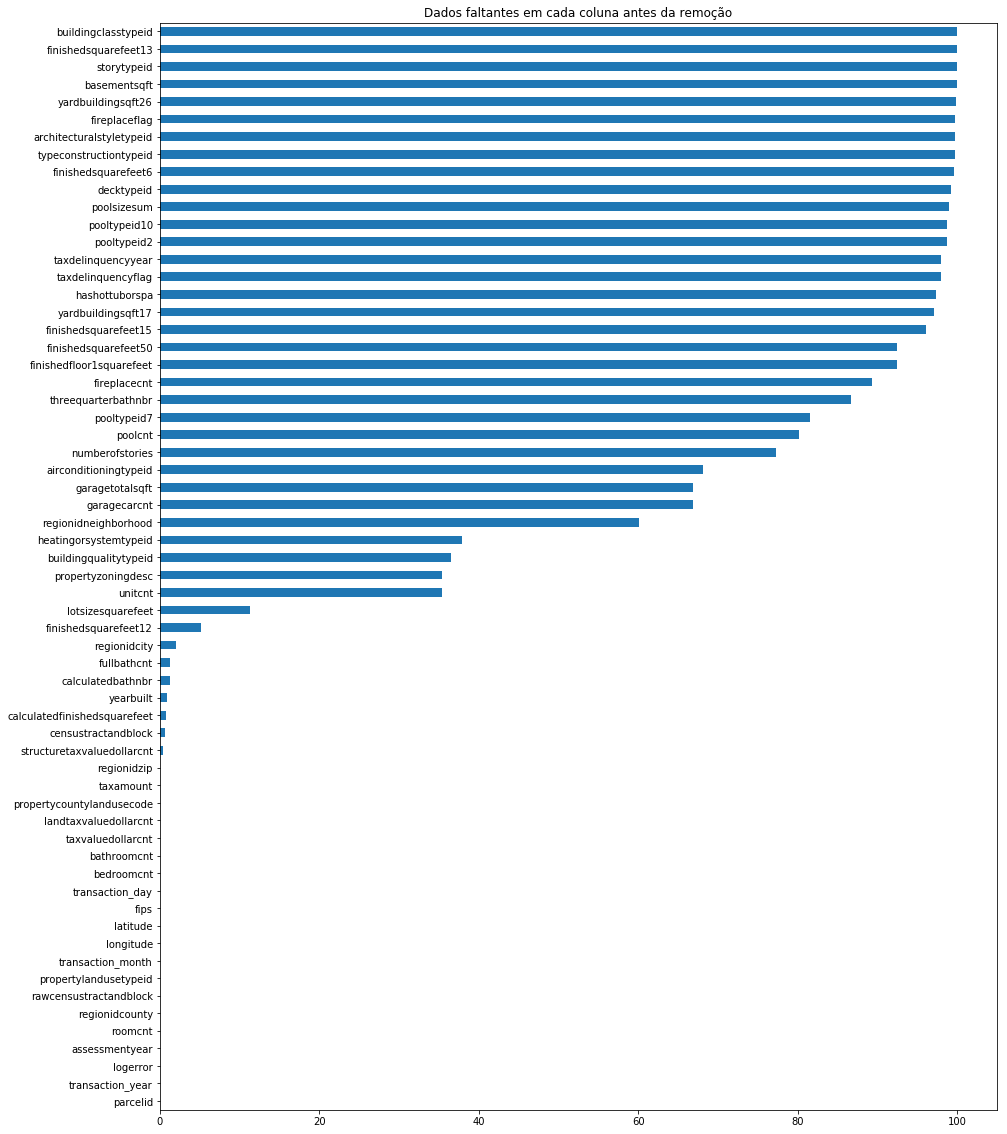

In [10]:
((props.isnull().sum()/len(props))*100).sort_values().plot.barh(figsize=(15,20), title='Dados faltantes em cada coluna antes da remoção')

#missingValueColumns = props.columns[props.isnull().any()].tolist()
#msno.bar(props[missingValueColumns])

#### 2.2.1 Remoção de dados

In [11]:
props.shape

(90275, 62)

##### Remoção de Instâncias

In [0]:
#df.dropna(thresh=2)   #Drop row if it does not have at least two values that are **not** NaN

# Remover linhas com mais de 70% de dados ausentes
props.dropna(thresh=(0.3*len(props.columns.values)), inplace=True)

##### Remoção de colunas

In [13]:
# A coluna 'assessmentyear' sempre tem o mesmo valor para todas as instâncias, logo se torna inútil mantê-la
print(props['assessmentyear'].value_counts())
props.drop(['assessmentyear'], axis=1, inplace=True)

2015.0    90275
Name: assessmentyear, dtype: int64


In [0]:
#A coluna 'fireplaceflag' não adiciona nenhuma informação útil pois o dataset já possui 'fireplacecnt', então removemos:
props.drop(['fireplaceflag'], axis=1, inplace=True)

#A coluna 'calculatedbathnbr' é uma cópia da coluna 'bathroomcnt', então removemos:
props.drop(['calculatedbathnbr'], axis=1, inplace=True)

#A coluna 'calculatedfinishedsquarefeet' é uma cópia da coluna 'finishedsquarefeet12', então removemos:
props.drop(['calculatedfinishedsquarefeet'], axis=1, inplace=True)

# Remover colunas com mais de 70% de dados ausentes
props.dropna(thresh=0.70*len(props), axis=1, inplace=True)

##### Dataframe Resultante

In [15]:
print('Dataframe Resultante: \n', props.shape)

props.head().transpose()

Dataframe Resultante: 
 (90275, 26)


,0,1,2,3,4
parcelid,17073783,17088994,17100444,17102429,17109604
bathroomcnt,2.5,1,2,1.5,2.5
bedroomcnt,3,2,3,2,4
finishedsquarefeet12,1264,777,1101,1554,2415
fips,6111,6111,6111,6111,6111
fullbathcnt,2,1,2,1,2
latitude,3.43036e+07,3.42729e+07,3.43408e+07,3.43543e+07,3.42666e+07
longitude,-1.19287e+08,-1.19199e+08,-1.1908e+08,-1.19076e+08,-1.19165e+08
lotsizesquarefeet,1735,NaN,6569,7400,6326
propertycountylandusecode,1128,1129,1111,1110,1111


In [16]:
nan_series_cols = props.isnull().sum()
print('Quantitativo de dados faltantes por coluna: \n')
nan_series_cols[nan_series_cols != 0].sort_values()
#nan_series_cols[nan_series_cols != 0].sort_values().plot.barh(figsize=(7,7), title='Quantidade de dados faltantes para as colunas que possuem')

Quantitativo de dados faltantes por coluna: 



propertycountylandusecode         1
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         6
regionidzip                      35
structuretaxvaluedollarcnt      380
censustractandblock             605
yearbuilt                       756
fullbathcnt                    1182
regionidcity                   1803
finishedsquarefeet12           4679
lotsizesquarefeet             10150
dtype: int64

#### 2.2.2 Imputação de dados

[Obtendo colunas que contém valores NaN](https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null)

In [0]:
nan_columns = props.columns[props.isnull().any()]

In [18]:
props[nan_columns].describe()

,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,85596.000000,89093.000000,8.012500e+04,88472.000000,90240.000000,89519.000000,8.989500e+04,9.027400e+04,9.027400e+04,90269.000000,8.967000e+04
mean,1745.454531,2.241231,2.911016e+04,33761.332851,96586.131184,1968.532870,1.800934e+05,4.576726e+05,2.783353e+05,5983.975927,6.049151e+13
std,909.941166,0.963142,1.217213e+05,46672.393863,3661.339094,23.763475,2.091299e+05,5.548844e+05,4.004955e+05,6838.876956,2.046605e+11
min,2.000000,1.000000,1.670000e+02,3491.000000,95982.000000,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13
25%,1172.000000,2.000000,5.703000e+03,12447.000000,96193.000000,1953.000000,8.124500e+04,1.990232e+05,8.222800e+04,2872.830000,6.037320e+13
50%,1518.000000,2.000000,7.200000e+03,25218.000000,96393.000000,1970.000000,1.320000e+05,3.428720e+05,1.929700e+05,4542.750000,6.037615e+13
75%,2056.000000,3.000000,1.168600e+04,45457.000000,96987.000000,1987.000000,2.105345e+05,5.405890e+05,3.454195e+05,6901.090000,6.059042e+13
max,20013.000000,20.000000,6.971010e+06,396556.000000,399675.000000,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13


##### Dados Categóricos [aqui](https://www.datacamp.com/community/tutorials/categorical-data) e [aqui](https://scikit-learn.org/stable/modules/impute.html)

In [0]:
cat_df_nan = props[nan_columns].select_dtypes(include=['category']).copy()

In [20]:
cat_df_nan.head()

,propertycountylandusecode
0,1128
1,1129
2,1111
3,1110
4,1111


In [21]:
print('Total NaN values in categorical columns: ' + str(cat_df_nan.isnull().values.sum()))
print(cat_df_nan.isnull().sum())

Total NaN values in categorical columns: 1
propertycountylandusecode    1
dtype: int64


In [0]:
category_type = props.select_dtypes(include=['category']).columns.values
for c in category_type:
  props[c] = props[c].cat.codes

##### Dados Numéricos

In [0]:
num_df_nan = props[nan_columns].select_dtypes(exclude=['category']).copy()
#num_nan = props[list(set(props.columns.values).difference(num_df_nan.columns.values))]

In [24]:
num_df_nan.head()

,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
0,1264.0,2.0,1735.0,54,34543.0,97081.0,1986.0,115087.0,191811.0,76724.0,2015.06,6.111002e+13
1,777.0,1.0,NaN,55,34543.0,97083.0,1990.0,143809.0,239679.0,95870.0,2581.30,6.111002e+13
2,1101.0,2.0,6569.0,50,26965.0,97113.0,1956.0,33619.0,47853.0,14234.0,591.64,6.111001e+13
3,1554.0,1.0,7400.0,49,26965.0,97113.0,1965.0,45609.0,62914.0,17305.0,682.78,6.111001e+13
4,2415.0,2.0,6326.0,50,34543.0,97084.0,1984.0,277000.0,554000.0,277000.0,5886.92,6.111001e+13


In [25]:
print('Total NaN values in numeric columns: {}'.format(num_df_nan.isnull().values.sum()))
print(num_df_nan.isnull().sum().sort_values())

Total NaN values in numeric columns: 19598
propertycountylandusecode         0
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         6
regionidzip                      35
structuretaxvaluedollarcnt      380
censustractandblock             605
yearbuilt                       756
fullbathcnt                    1182
regionidcity                   1803
finishedsquarefeet12           4679
lotsizesquarefeet             10150
dtype: int64


Usando Random Forest para imputação de dados

In [0]:
def saveToCsv(df, columns, index):
  
  df_out = pd.DataFrame(data=df)
  df_out.columns = props.columns.values.tolist()
  df_out.set_index(index, inplace=True, drop=True)
  df_out.to_csv('props_imputed.csv')
  
  from google.colab import files
  files.download('props_imputed.csv')

In [0]:
'''

  Se já executou anteriormente, settar imputed para True.
  Se não, settar imputed para False para fazer a imputação.
  
'''

if(imputed):
  props_imputed = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/props_imputed_v2.csv',
                             header=0, sep=',', quotechar='"')
else:
  from missingpy import MissForest
  imputer = MissForest()
  props_imputed = imputer.fit_transform(props)
  saveToCsv(props_imputed, props.columns.values.tolist(), 'parcelid')

In [0]:
# Executar o kNN com o dataframe causará estouro de memória

#lb_make = LabelEncoder()
#props['propertycountylandusecode'] = lb_make.fit_transform(props['propertycountylandusecode'])

#props_knn = KNN(k=3).fit_transform(props)

Comparação das estatísticas antes e depois da imputação.

In [29]:
props[nan_columns].describe()

,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,85596.000000,89093.000000,8.012500e+04,90275.000000,88472.000000,90240.000000,89519.000000,8.989500e+04,9.027400e+04,9.027400e+04,90269.000000,8.967000e+04
mean,1745.454531,2.241231,2.911016e+04,24.315071,33761.332851,96586.131184,1968.532870,1.800934e+05,4.576726e+05,2.783353e+05,5983.975927,6.049151e+13
std,909.941166,0.963142,1.217213e+05,25.738982,46672.393863,3661.339094,23.763475,2.091299e+05,5.548844e+05,4.004955e+05,6838.876956,2.046605e+11
min,2.000000,1.000000,1.670000e+02,-1.000000,3491.000000,95982.000000,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13
25%,1172.000000,2.000000,5.703000e+03,2.000000,12447.000000,96193.000000,1953.000000,8.124500e+04,1.990232e+05,8.222800e+04,2872.830000,6.037320e+13
50%,1518.000000,2.000000,7.200000e+03,9.000000,25218.000000,96393.000000,1970.000000,1.320000e+05,3.428720e+05,1.929700e+05,4542.750000,6.037615e+13
75%,2056.000000,3.000000,1.168600e+04,55.000000,45457.000000,96987.000000,1987.000000,2.105345e+05,5.405890e+05,3.454195e+05,6901.090000,6.059042e+13
max,20013.000000,20.000000,6.971010e+06,76.000000,396556.000000,399675.000000,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13


In [30]:
props_imputed[nan_columns].describe()

,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,90275.000000,90275.000000,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,9.027500e+04
mean,1766.497488,2.225189,2.912494e+04,24.315071,33961.479352,96586.314028,1968.502799,1.794753e+05,4.576713e+05,2.783341e+05,5983.760300,6.049185e+13
std,912.601389,0.967107,1.159982e+05,25.738982,46337.300549,3660.641858,23.757301,2.089603e+05,5.548815e+05,4.004934e+05,6838.704246,2.050521e+11
min,2.000000,1.000000,1.670000e+02,-1.000000,3491.000000,95982.000000,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13
25%,1183.000000,2.000000,5.741000e+03,2.000000,12447.000000,96193.000000,1953.000000,8.074700e+04,1.990235e+05,8.222800e+04,2872.600000,6.037400e+13
50%,1539.000000,2.000000,7.375000e+03,9.000000,25218.000000,96393.000000,1970.000000,1.315660e+05,3.428720e+05,1.929600e+05,4542.440000,6.037620e+13
75%,2096.000000,3.000000,1.382729e+04,55.000000,45602.000000,96987.000000,1987.000000,2.100780e+05,5.405890e+05,3.454150e+05,6900.600000,6.059042e+13
max,20013.000000,20.000000,6.971010e+06,76.000000,396556.000000,399675.000000,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13


Mostrando histograma para uma coluna antes e depois da imputação - TENTAR COLOCAR NO MESMO SUBPLOT

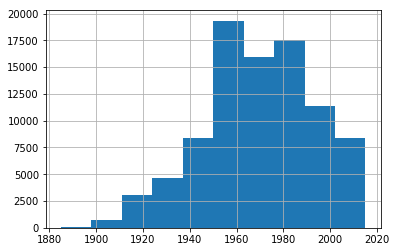

In [31]:
props['yearbuilt'].hist()

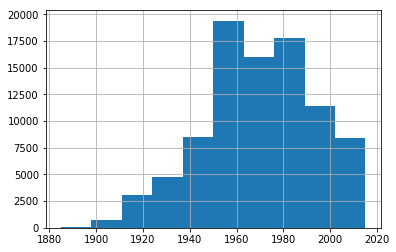

In [32]:
props_imputed['yearbuilt'].hist()

In [0]:
props = props_imputed.copy()

In [34]:
print('Total NaN values after imputation: {}'.format(props.isnull().values.sum()))

Total NaN values after imputation: 0


### 2.3 Normalização e discretização

In [0]:
# Salvar coluna de IDs
parcelid = props['parcelid'].copy()

#### 2.3.1 Discretização

In [36]:
props['taxvaluedollarcnt'].describe()

count    9.027500e+04
mean     4.576713e+05
std      5.548815e+05
min      2.200000e+01
25%      1.990235e+05
50%      3.428720e+05
75%      5.405890e+05
max      2.775000e+07
Name: taxvaluedollarcnt, dtype: float64

In [0]:
#props['tax_value_intervals'] = pd.qcut(props['taxvaluedollarcnt'], 20)

In [38]:
# Pyspark QuantileDiscretizer: Discretizar a coluna 'taxvaluedollarcnt'
props_spark = spark.createDataFrame(props,props.columns.values.tolist())
props_spark_result = QuantileDiscretizer(numBuckets=10, inputCol="taxvaluedollarcnt",outputCol="area_intervals").fit(props_spark).transform(props_spark)
props_spark_result.show()

+-----------+-----------+----------+--------------------+------+-----------+-----------+-------------+-----------------+-------------------------+---------------------+----------------------+------------+--------------+-----------+-------+---------+--------------------------+-----------------+---------------------+---------+-------------------+--------------------+----------------+-----------------+---------------+--------------+
|   parcelid|bathroomcnt|bedroomcnt|finishedsquarefeet12|  fips|fullbathcnt|   latitude|    longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|landtaxvaluedollarcnt|taxamount|censustractandblock|            logerror|transaction_year|transaction_month|transaction_day|area_intervals|
+-----------+-----------+----------+--------------------+------+-----------+-----------+-------------+-----------------+------------

#### 2.3.2 Normalização

In [39]:
min_max_scaler = preprocessing.MinMaxScaler()
props = pd.DataFrame(min_max_scaler.fit_transform(props), columns=props.columns, index=props.index)

props.describe()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day
count,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,...,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000
mean,0.014929,0.113974,0.189492,0.088176,0.160413,0.064484,0.451080,0.659818,0.004154,0.328767,...,0.642329,0.018031,0.016492,0.011360,0.018437,0.163493,0.494162,0.0,0.440895,0.511317
std,0.016450,0.050214,0.072277,0.045605,0.279236,0.050900,0.179429,0.190499,0.016640,0.334272,...,0.182748,0.021005,0.019996,0.016347,0.021246,0.277442,0.017242,0.0,0.255699,0.300286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.005568,0.100000,0.125000,0.059018,0.000000,0.052632,0.319793,0.547388,0.000800,0.038961,...,0.523077,0.008107,0.007171,0.003355,0.008772,0.004047,0.490227,0.0,0.272727,0.233333
50%,0.012057,0.100000,0.187500,0.076808,0.000000,0.052632,0.461975,0.673256,0.001034,0.129870,...,0.653846,0.013215,0.012355,0.007875,0.013959,0.007025,0.493577,0.0,0.454545,0.500000
75%,0.023093,0.150000,0.250000,0.104642,0.297297,0.105263,0.564393,0.806299,0.001960,0.727273,...,0.784615,0.021108,0.019480,0.014098,0.021285,0.296872,0.497131,0.0,0.636364,0.766667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [40]:
props.head()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day
0,0.041787,0.125,0.1875,0.063065,1.0,0.052632,0.653005,0.084857,0.000225,0.714286,...,0.776923,0.011559,0.006911,0.003131,0.006108,0.999907,0.503136,0.0,0.000000,0.866667
1,0.041887,0.050,0.1250,0.038729,1.0,0.000000,0.632195,0.131517,0.000538,0.727273,...,0.807692,0.014446,0.008636,0.003912,0.007867,0.999897,0.495055,0.0,0.181818,0.966667
2,0.041962,0.100,0.1875,0.054920,1.0,0.052632,0.678199,0.194541,0.000918,0.662338,...,0.546154,0.003369,0.001724,0.000580,0.001686,0.999886,0.493577,0.0,0.363636,0.866667
3,0.041975,0.075,0.1250,0.077557,1.0,0.000000,0.687349,0.196234,0.001038,0.649351,...,0.615385,0.004575,0.002266,0.000705,0.001969,0.999888,0.486876,0.0,0.454545,0.200000
4,0.042022,0.125,0.2500,0.120584,1.0,0.052632,0.627937,0.149224,0.000884,0.662338,...,0.761538,0.027835,0.019963,0.011305,0.018136,0.999896,0.499069,0.0,0.636364,0.233333


Recuperando os IDs que foram normalizados

In [0]:
props['parcelid'] = parcelid

### 2.4 [Limpeza de dados](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

#### 2.4.1 Univariado [aqui](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba) e [aqui](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)

"The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.""

Colunas que possuem média menor que o desvio padrão apresentam forte indício de outliers.

In [42]:
props.loc[:, props.mean() < props.std()].columns.values

array(['fips', 'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidzip', 'roomcnt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock'],
      dtype=object)

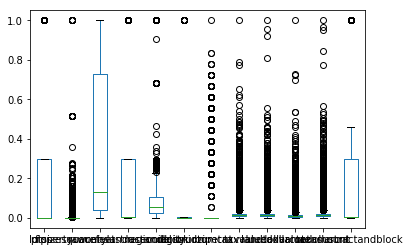

In [43]:
# CRIAR VÁRIOS SUBPLOTS PARA CADA BOXPLOT
props.loc[:, props.mean() < props.std()].plot.box()

In [44]:
props['taxvaluedollarcnt'].describe()

count    90275.000000
mean         0.016492
std          0.019996
min          0.000000
25%          0.007171
50%          0.012355
75%          0.019480
max          1.000000
Name: taxvaluedollarcnt, dtype: float64

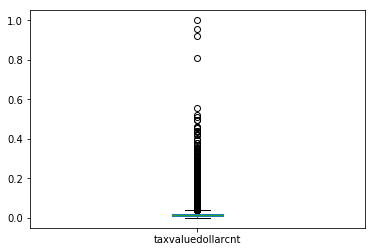

In [45]:
props['taxvaluedollarcnt'].plot.box()

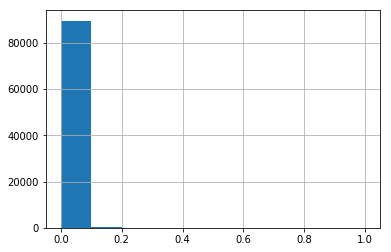

In [46]:
props['taxvaluedollarcnt'].hist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


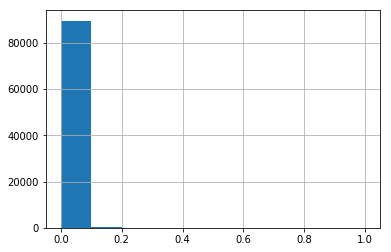

In [47]:
from numpy import log10
props['total_tax_log'] = log10(props['taxvaluedollarcnt'])
props['taxvaluedollarcnt'].hist()

In [48]:
# TEST
from scipy import stats
props[(np.abs(stats.zscore(props)) < 10).all(axis=1)]

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in subtract
  return (a - mns) / sstd
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day,total_tax_log


#### 2.4.2 Bivariado

#### 2.4.3 Multivariado

## Criação de Novas Features

## Visualização de Dados

#### Distribuição da localização das propriedades

In [0]:
props['latitude'] /= 1e6
props['longitude'] /= 1e6

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

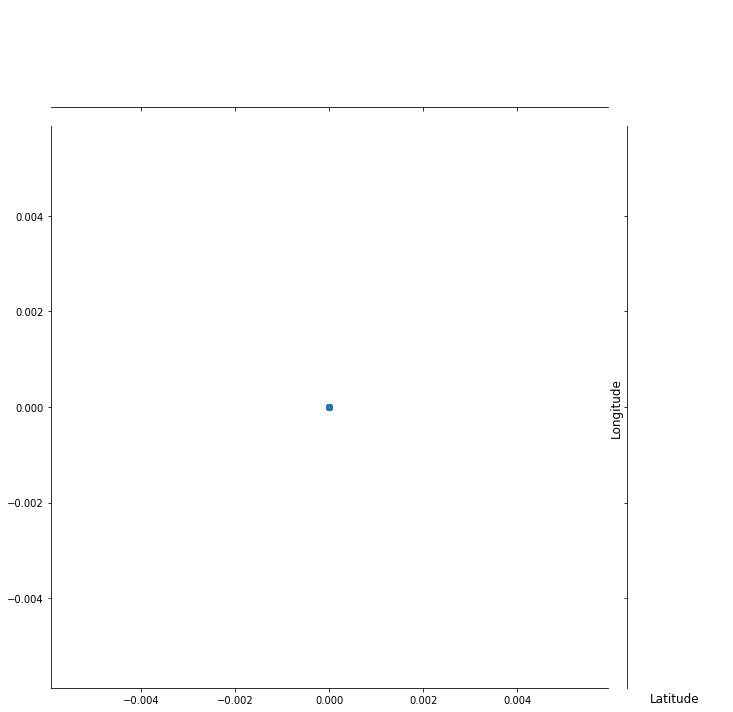

In [50]:
plt.figure(figsize=(12,12))
sns.jointplot(x=props.latitude.values, y=props.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [0]:
#Save for later

#Get all null columns as dataframe 
#print(props[props.isnull().any(axis=1)][nan_columns].head())

#props_train = pd.merge(props, train, on='parcelid', how='left')

#msno.dendrogram(props)

# Changing type of columns with Ids to unsigned short int
#id_columns = props.filter(regex='id').columns.values
#props[id_columns] = props[id_columns].astype('uint16')

# Para a coluna propertycountylandusecode não precisamos de imputação, logo apenas transformamos as categorias para código
# cat_df_props['propertycountylandusecode'] = cat_df_props['propertycountylandusecode'].cat.codes.astype('int16')
#cat_df_props['propertyzoningdesc'] = cat_df_props['propertyzoningdesc'].cat.codes.astype('int16')

#msno.heatmap(props[nan_columns], figsize=(15,15))
# All Columns Correlation
#f,ax = plt.subplots(figsize=(15, 15))
#sns.heatmap(props.corr(), annot=True, linewidths=.5, fmt='.1f',ax=ax)
#plt.show()

###############################################################################################################################

# b = abs(props.drop(['parcelid'], axis=1).mean() - props.drop(['parcelid'], axis=1).median()).nlargest(5)

#Para excluir

# Não podemos usar o one hot encoder pois precisariamos criar 240 novas colunas para um dataframe com 3 mi instâncias
#cat_df_props['propertycountylandusecode'].cat.categories

#prop_county_land_use_code = cat_df_props['propertycountylandusecode'].cat.codes
#prop_county_land_use_code

#lb_make = LabelEncoder()
#cat_df_props['propertycountylandusecode'] = lb_make.fit_transform(cat_df_props['propertycountylandusecode'])

# Algumas estatísticas Descritivas

In [52]:
props_imputed.describe()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day
count,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,...,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,9.027500e+04,90275.000000,90275.0,90275.000000,90275.000000
mean,1.298466e+07,2.279474,3.031869,1766.497488,6048.870551,2.225189,3.400541e+07,-1.181989e+08,2.912494e+04,24.315071,...,1968.502799,1.794753e+05,4.576713e+05,2.783341e+05,5983.760300,6.049185e+13,0.011457,2016.0,5.849848,16.339507
std,2.504510e+06,1.004271,1.156436,912.601389,20.663461,0.967107,2.649654e+05,3.606032e+05,1.159982e+05,25.738982,...,23.757301,2.089603e+05,5.548815e+05,4.004934e+05,6838.704246,2.050521e+11,0.161079,0.0,2.812690,9.008589
min,1.071174e+07,0.000000,0.000000,2.000000,6037.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,-1.000000,...,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13,-4.605000,2016.0,1.000000,1.000000
25%,1.155950e+07,2.000000,2.000000,1183.000000,6037.000000,2.000000,3.381154e+07,-1.184117e+08,5.741000e+03,2.000000,...,1953.000000,8.074700e+04,1.990235e+05,8.222800e+04,2872.600000,6.037400e+13,-0.025300,2016.0,4.000000,8.000000
50%,1.254734e+07,2.000000,3.000000,1539.000000,6037.000000,2.000000,3.402150e+07,-1.181734e+08,7.375000e+03,9.000000,...,1970.000000,1.315660e+05,3.428720e+05,1.929600e+05,4542.440000,6.037620e+13,0.006000,2016.0,6.000000,16.000000
75%,1.422755e+07,3.000000,4.000000,2096.000000,6059.000000,3.000000,3.417274e+07,-1.179216e+08,1.382729e+04,55.000000,...,1987.000000,2.100780e+05,5.405890e+05,3.454150e+05,6900.600000,6.059042e+13,0.039200,2016.0,8.000000,24.000000
max,1.629608e+08,20.000000,16.000000,20013.000000,6111.000000,20.000000,3.481601e+07,-1.175549e+08,6.971010e+06,76.000000,...,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13,4.737000,2016.0,12.000000,31.000000


In [53]:
props_imputed.shape

(90275, 26)

In [54]:
props_imputed.axes

[RangeIndex(start=0, stop=90275, step=1),
 Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'fips',
        'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
        'propertycountylandusecode', 'propertylandusetypeid',
        'rawcensustractandblock', 'regionidcity', 'regionidcounty',
        'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
        'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
        'censustractandblock', 'logerror', 'transaction_year',
        'transaction_month', 'transaction_day'],
       dtype='object')]

# Testes de Hipóteses

testar se o ano das casas segue a mesma distribuição da área

In [55]:
props_imputed['yearbuilt']

0        1986.0
1        1990.0
2        1956.0
3        1965.0
4        1984.0
5        1980.0
6        1978.0
7        1971.0
8        1979.0
9        1950.0
10       1969.0
11       1984.0
12       1962.0
13       1981.0
14       1964.0
15       1961.0
16       1965.0
17       1976.0
18       1980.0
19       1985.0
20       1985.0
21       1963.0
22       1969.0
23       1993.0
24       1988.0
25       1970.0
26       1982.0
27       1960.0
28       1959.0
29       1963.0
          ...  
90245    2004.0
90246    2003.0
90247    2005.0
90248    2006.0
90249    2005.0
90250    1988.0
90251    1988.0
90252    2004.0
90253    2006.0
90254    2006.0
90255    2005.0
90256    2007.0
90257    2007.0
90258    2013.0
90259    2007.0
90260    2006.0
90261    2005.0
90262    1928.0
90263    2008.0
90264    2004.0
90265    2006.0
90266    2007.0
90267    2007.0
90268    2007.0
90269    2007.0
90270    2008.0
90271    1956.0
90272    2011.0
90273    2012.0
90274    2013.0
Name: yearbuilt, Length: